In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [2]:
df = pd.read_excel("band_powers_labels_FULL_FINAL_grad.xlsx")  

# Drop rows with empty Target values
df = df.dropna(subset=['Target'])

In [3]:
import pandas as pd
df_normal = df.copy()
target_cols = df_normal.columns[-3:]
# Extract subject number from 'File Name'
df_normal['Subject'] = df_normal['File Name'].str.extract(r's(\d+)').astype(int)

# Get feature columns (excluding 'File Name' and 'Subject')
feature_cols = df_normal.columns.difference(['File Name', 'Subject']).difference(target_cols)

# Normalize per subject
df_normal[feature_cols] = df_normal.groupby('Subject')[feature_cols].transform(lambda x: (x - x.mean()) / x.std())


In [4]:
df_valence = df_normal.copy()
df_valence=df_valence.drop(columns=['TargetArousal'])
df_valence=df_valence.drop(columns=['Target'])

In [5]:
df_arousal = df_normal.copy()
df_arousal=df_arousal.drop(columns=['TargetValence'])
df_arousal=df_arousal.drop(columns=['Target'])

In [6]:
def split_within_subject(df, train_ratio=0.8):
    train_list = []
    test_list = []
    
    for subject, group in df.groupby("Subject"):
        if len(group) != 60:
            raise ValueError(f"Subject {subject} does not have exactly 60 samples!")

        # Shuffle samples within each subject
        group = group.sample(frac=1, random_state=42)

        # Determine train-test split indices
        train_size = int(train_ratio * len(group))  # 80% of 60 = 48
        train_list.append(group.iloc[:train_size])  # First 48 samples → Train
        test_list.append(group.iloc[train_size:])   # Last 12 samples → Test

    # Combine the lists into DataFrames
    train_df = pd.concat(train_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)

    return train_df, test_df

In [7]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

df_valence = df_valence.iloc[:, 1:]  # Excludes the first and last columns

# Apply the function to split data
train_val, test_val = split_within_subject(df_valence)

# Extract features and target
X_train_val = train_val.drop(columns=['Subject', 'TargetValence'])
y_train_val = train_val['TargetValence']

X_test_val = test_val.drop(columns=['Subject', 'TargetValence'])
y_test_val = test_val['TargetValence']

# Standardize the features
scaler_val = StandardScaler()
X_train_val = scaler_val.fit_transform(X_train_val)
X_test_val = scaler_val.transform(X_test_val)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform target labels
y_train_val_encoded = label_encoder.fit_transform(y_train_val)
y_test_val_encoded = label_encoder.transform(y_test_val)

# Initialize XGBoost classifier
clf_xgb_val = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1,
    use_label_encoder=False
)

clf_xgb_val.fit(X_train_val, y_train_val_encoded)

# Predict on the test set
y_pred_xgb_val = clf_xgb_val.predict(X_test_val)

# Convert predictions back to original labels
y_pred_xgb_original_val = label_encoder.inverse_transform(y_pred_xgb_val)

# Evaluate model performance
print("Accuracy for Valence:", accuracy_score(y_test_val, y_pred_xgb_original_val))
print("Classification Report:\n", classification_report(y_test_val, y_pred_xgb_original_val))


Accuracy for Valence: 0.8351063829787234
Classification Report:
               precision    recall  f1-score   support

          NV       0.81      0.84      0.82       256
          PV       0.86      0.83      0.85       308

    accuracy                           0.84       564
   macro avg       0.83      0.84      0.83       564
weighted avg       0.84      0.84      0.84       564



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Observed accuracy using the true labels
y_pred_original = clf_xgb_val.predict(X_test_val)
observed_acc = accuracy_score(y_test_val, y_pred_xgb_original_val)

# 2. Permutation test: shuffle labels and retrain the model
n_permutations = 100
perm_accuracies = []

for _ in range(n_permutations):
    # Shuffle the training labels
    y_train_perm = np.random.permutation(y_train_val)
    
    # Clone or re-initialize your model to reset it
    model_perm = XGBClassifier(**clf_xgb_val.get_params()) 
    y_train_perm = label_encoder.fit_transform(y_train_perm)
    # Fit model on the same training data but with permuted labels
    model_perm.fit(X_train_val, y_train_perm)
    
    # Predict on the original test set
    y_pred_perm = model_perm.predict(X_test_val)
    
    # Compute accuracy and store it
    perm_acc = accuracy_score(y_test_val_encoded, y_pred_perm)
    perm_accuracies.append(perm_acc)

# 3. Calculate p-value
perm_accuracies = np.array(perm_accuracies)
p_value = np.mean(perm_accuracies >= observed_acc)

print(f"Permutation test p-value: {p_value:.4f}")
print(f"Mean of permutation accuracies: {np.mean(perm_accuracies):.4f}")


Permutation test p-value: 0.0000
Mean of permutation accuracies: 0.5035


In [ ]:
import numpy as np

# 1. Observed accuracy
observed_acc = accuracy_score(y_test_val, y_pred_xgb_original_val)

# 2. Permutation test
n_permutations = 100
perm_accuracies = []

for _ in range(n_permutations):
    y_test_perm = np.random.permutation(y_test_val)  # shuffle the true labels
    perm_acc = accuracy_score(y_test_perm, y_pred_xgb_original_val)
    perm_accuracies.append(perm_acc)

# 3. Calculate p-value
perm_accuracies = np.array(perm_accuracies)
p_value = np.mean(perm_accuracies >= observed_acc)

print(f"Permutation test p-value: {p_value:.4f}")
print(f"Mean of permutaion accuratcies: { np.mean(perm_accuracies)}")


Permutation test p-value: 0.0000
Mean of permutaion accuratcies: 0.5036524822695035


            Feature  Importance
680    Beta MEG1012    0.009409
157   Delta MEG2113    0.009030
621    Beta MEG0213    0.007873
567   Alpha MEG2123    0.007825
178   Delta MEG2342    0.007799
...             ...         ...
450   Alpha MEG0622    0.000000
452   Alpha MEG0632    0.000000
453   Alpha MEG0633    0.000000
454   Alpha MEG0642    0.000000
1019  Gamma MEG2643    0.000000

[1020 rows x 2 columns]


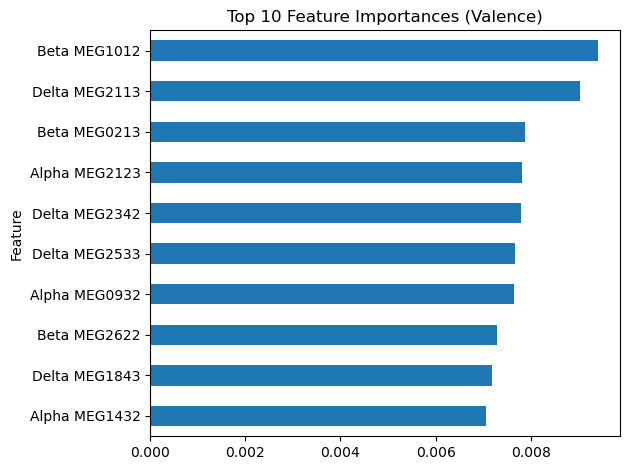

In [ ]:
# Get feature importances
importances = clf_xgb_val.feature_importances_

feature_names = train_val.drop(columns=['Subject', 'TargetValence']).columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

top_n = 10
feature_importance_df.head(top_n).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title(f'Top {top_n} Feature Importances (Valence)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [17]:
from sklearn.preprocessing import LabelEncoder

df_arousal = df_arousal.iloc[:, 1:]  # Excludes the first and last columns

# Apply the function
train_ar, test_ar = split_within_subject(df_arousal)

# Extract X and y
X_train_ar = train_ar.drop(columns=['Subject', 'TargetArousal'])
y_train_ar = train_ar['TargetArousal']

X_test_ar = test_ar.drop(columns=['Subject', 'TargetArousal'])
y_test_ar = test_ar['TargetArousal']

# Standardize features
scaler_ar = StandardScaler()
X_train_ar = scaler_ar.fit_transform(X_train_ar)
X_test_ar = scaler_ar.transform(X_test_ar)

#  Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform y_train_val and y_test_val to convert labels to numbers
y_train_ar_encoded = label_encoder.fit_transform(y_train_ar)
y_test_ar_encoded = label_encoder.transform(y_test_ar)

clf_xgb_ar = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=1,
    use_label_encoder=False
)

# Train the model
clf_xgb_ar.fit(X_train_ar, y_train_ar_encoded)

# Predict
y_pred_xgb_ar = clf_xgb_ar.predict(X_test_ar)

# Convert predictions back to original labels
y_pred_xgb_original_ar = label_encoder.inverse_transform(y_pred_xgb_ar)

# Evaluate
print("Accuracy for Arousal:", accuracy_score(y_test_ar, y_pred_xgb_original_ar))
print("Classification Report:\n", classification_report(y_test_ar, y_pred_xgb_original_ar))


Accuracy for Arousal: 0.7801418439716312
Classification Report:
               precision    recall  f1-score   support

          HA       0.76      0.72      0.74       246
          LA       0.79      0.82      0.81       318

    accuracy                           0.78       564
   macro avg       0.78      0.77      0.78       564
weighted avg       0.78      0.78      0.78       564



In [21]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Observed accuracy using the true labels
y_pred_original = clf_xgb_ar.predict(X_test_ar)
observed_acc = accuracy_score(y_test_ar, y_pred_xgb_original_ar)

# 2. Permutation test: shuffle labels and retrain the model
n_permutations = 100
perm_accuracies = []

for _ in range(n_permutations):
    # Shuffle the training labels
    y_train_perm = np.random.permutation(y_train_ar)
    
    # Clone or re-initialize your model to reset it
    model_perm = XGBClassifier(**clf_xgb_ar.get_params()) 
    y_train_perm = label_encoder.fit_transform(y_train_perm)
    # Fit model on the same training data but with permuted labels
    model_perm.fit(X_train_ar, y_train_perm)
    
    # Predict on the original test set
    y_pred_perm = model_perm.predict(X_test_ar)
    
    # Compute accuracy and store it
    perm_acc = accuracy_score(y_test_ar_encoded, y_pred_perm)
    perm_accuracies.append(perm_acc)

# 3. Calculate p-value
perm_accuracies = np.array(perm_accuracies)
p_value = np.mean(perm_accuracies >= observed_acc)

print(f"Permutation test p-value: {p_value:.4f}")
print(f"Mean of permutation accuracies: {np.mean(perm_accuracies):.4f}")


Permutation test p-value: 0.0000
Mean of permutation accuracies: 0.5093


In [ ]:
import numpy as np

# 1. Observed accuracy
observed_acc = accuracy_score(y_test_ar, y_pred_xgb_original_ar)

# 2. Permutation test
n_permutations = 100
perm_accuracies = []

for _ in range(n_permutations):
    y_test_perm = np.random.permutation(y_test_ar)  # shuffle the true labels
    perm_acc = accuracy_score(y_test_perm, y_pred_xgb_original_ar)
    perm_accuracies.append(perm_acc)

# 3. Calculate p-value
perm_accuracies = np.array(perm_accuracies)
p_value = np.mean(perm_accuracies >= observed_acc)

print(f"Permutation test p-value: {p_value:.4f}")
print(f"Mean of permutaion accuratcies: { np.mean(perm_accuracies)}")


Permutation test p-value: 0.0000
Mean of permutaion accuratcies: 0.5113829787234042


            Feature  Importance
796    Beta MEG2432    0.009507
442   Alpha MEG0522    0.009072
964   Gamma MEG2012    0.008859
686    Beta MEG1042    0.008586
798    Beta MEG2442    0.008400
...             ...         ...
426   Alpha MEG0322    0.000000
427   Alpha MEG0323    0.000000
428   Alpha MEG0332    0.000000
430   Alpha MEG0342    0.000000
1019  Gamma MEG2643    0.000000

[1020 rows x 2 columns]


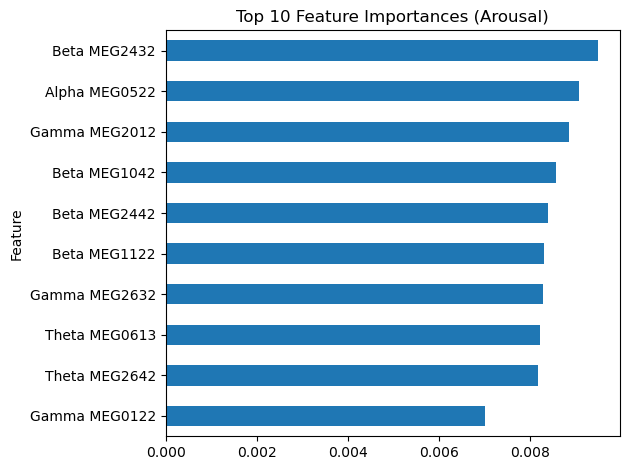

In [ ]:
# Get feature importances
importances = clf_xgb_ar.feature_importances_

feature_names = train_ar.drop(columns=['Subject', 'TargetArousal']).columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

top_n = 10
feature_importance_df.head(top_n).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title(f'Top {top_n} Feature Importances (Arousal)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
